In [1]:
from pathlib import Path
from patchnetvlad.training_tools.msls import MSLS
from patchnetvlad.training_tools.kitti360panorama import KITTI360PANORAMA
from patchnetvlad.training_tools.kitti360panorama import ImagesFromList
from submodules.mapillary_sls.mapillary_sls.utils.utils import configure_transform
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2
from submodules.mapillary_sls.mapillary_sls.utils.visualize import denormalize, visualize_triplets
from submodules.mapillary_sls.mapillary_sls.utils.eval import download_msls_sample

# Download MSLS sample

In [2]:
SAMPLE_CITIES_TEST = "3"
SAMPLE_CITIES_TRAIN = "0"

root_dir = Path('/data-lyh/').absolute()
print(root_dir)

/data-lyh



# Load dataset for testing


In [3]:
# get transform
meta = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}
transform = configure_transform(image_dim = (1400, 2800), meta = meta)

# positive are defined within a radius of 25 m
posDistThr = 25 #25

# choose task to test on [im2im, seq2im, im2seq, seq2seq]
task = 'im2im'

# choose sequence length
seq_length = 1
# no subtask is set for KITTI360 
val_dataset = KITTI360PANORAMA(root_dir, cities = SAMPLE_CITIES_TEST, transform = transform, mode = 'test',
                   task = task, seq_length = seq_length, posDistThr = posDistThr)

opt = {'batch_size': 2}

# get images
print(len(val_dataset.qImages))
print(len(val_dataset.qIdx))
print(len(val_dataset.dbImages))
qLoader = DataLoader(ImagesFromList(val_dataset.qImages[val_dataset.qIdx], transform), **opt)
dbLoader = DataLoader(ImagesFromList(val_dataset.dbImages, transform), **opt)

# get positive index (we allow some more slack: default 25 m)
pIdx = val_dataset.pIdx
print(pIdx)

=====> 2013_05_28_drive_0003_sync
404
404
606
[]


In [4]:
num_batches = len(qLoader)
# Calculate the total number of data samples
total_samples = num_batches * qLoader.batch_size
print("Number of batches:", num_batches)
print("Total number of data samples:", total_samples)
# batch is a brunch of datase in a mini-batch size (qLoader.batch_size), the number of batch is num_batches
# for batch in qLoader:
#     x, y = batch
#     print(type(x))
#     print(y)
#     plt.figure(figsize=(30,20))
#     for i,im in enumerate(x):
#         #plt.subplot(1,seq_length, i+1)
#         plt.imshow(im[0])
#     plt.show()

Number of batches: 202
Total number of data samples: 404


len(x) 2
tensor([0, 1])


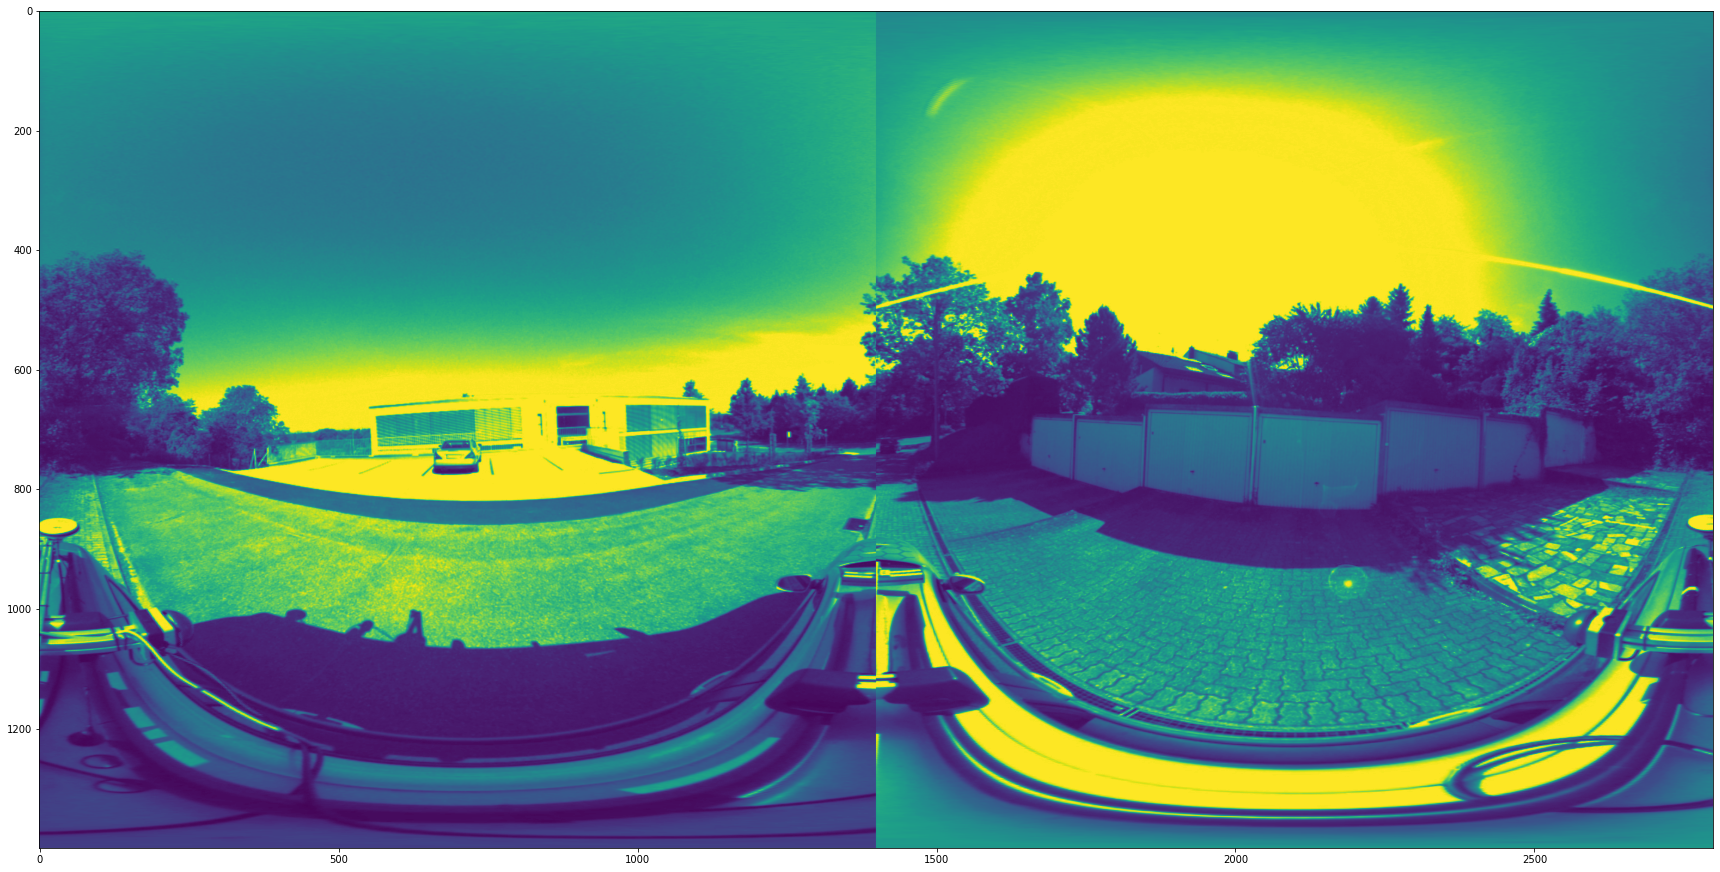

In [8]:
for batch in dbLoader:
    x, y = batch
    print('len(x)',len(x))
    print(y)
    plt.figure(figsize=(30,20))
    for i,im in enumerate(x):
        #plt.subplot(1,seq_length, i+1)
        #print(im[0].shape)
        #plt.imshow(denormalize(im[i]))
        plt.imshow(im[i])
    plt.show() 
    break

# Load dataset for training (triplets)

In [6]:
posDistThr = 3

# negatives are defined outside a radius of 25 m
negDistThr = 10

# number of negatives per triplet
nNeg = 5

# number of cached queries
cached_queries = 1

# number of cached negatives, why there are so many negatives cached?
cached_negatives = 100

# whether to use positive sampling
positive_sampling = True

# choose the cities to load
cities = SAMPLE_CITIES_TRAIN

# choose task to test on [im2im, seq2im, im2seq, seq2seq]
task = 'im2im'

# choose sequence length, why the seq_length should be odd number under seq2seq mode?
seq_length = 1

train_dataset = KITTI360PANORAMA(root_dir, cities = cities, transform = transform, mode = 'train', task = task, seq_length = seq_length,
                    negDistThr = negDistThr, posDistThr = posDistThr, nNeg = nNeg, cached_queries = cached_queries,
                    cached_negatives = cached_negatives)

=====> 2013_05_28_drive_0000_sync
2428


/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


1


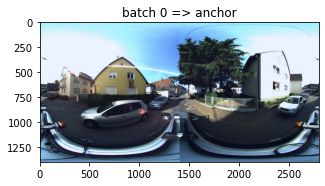

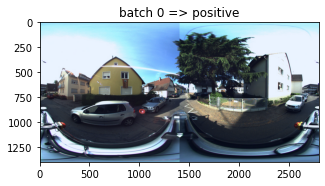

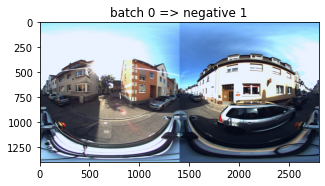

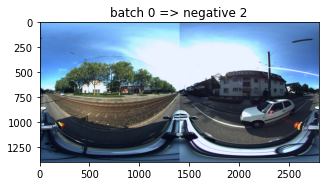

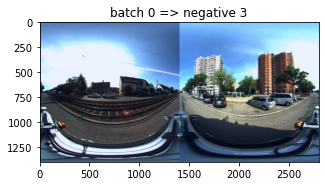

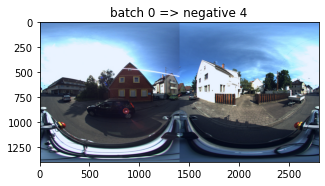

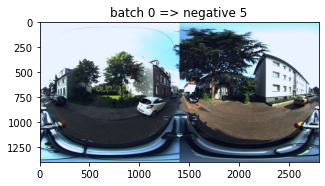

In [10]:
# divides dataset into smaller cache sets
train_dataset.new_epoch()

# creates triplets on the smaller cache set
train_dataset.update_subcache()

# create data loader
opt = {'batch_size': 1, 'shuffle': False}
trainDataloader = DataLoader(train_dataset, **opt)

# visualize a triplet
for batch in trainDataloader:
    print(len(trainDataloader))
    visualize_triplets(batch, task)